# Snapshot Serengeti Inception-V3

## Disclaimer
This uses the pre-built and open source inception v3 model as a baseline.
For more information see https://www.tensorflow.org/tutorials/image_recognition#usage_with_python_api.
You can also find the original source code that is modified here at https://github.com/tensorflow/models

## Setup

In [83]:
# Jupyter Imports
from IPython.display import Image

# Basic Data Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Google Inception Imports
from six.moves import urllib
import os
import sys
import tarfile
import re

# African Elephant, Tusker, Indian Elephant
elephant_nodes = {24, 214, 914}
ELEPHANT_THRESHOLD = 0.5

In [3]:
# Default codebase is vagrant
# If you aren't using vagrant replace codebase with your personal
# root.  For example, ~/home/projects/code-base
CODEBASE_DIR = '/vagrant'

# General Constants
DATA_DIR = CODEBASE_DIR + '/data'
MODEL_DIR = CODEBASE_DIR + '/models'

# Google Constants
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
DEST_DIRECTORY = MODEL_DIR +'/inceptionv3'
NUM_TOP_PREDICTIONS = 5

# Global State
GRAPH_STARTED = False

np.random.seed(1)

In [4]:
class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          DEST_DIRECTORY, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          DEST_DIRECTORY, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]

In [5]:
# Download Google Incpetion v3 Model
# Based on https://www.tensorflow.org/tutorials/image_recognition#usage_with_python_api

def maybe_download_and_extract():
  """Download and extract model tar file."""
  if not os.path.exists(DEST_DIRECTORY):
    os.makedirs(DEST_DIRECTORY)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(DEST_DIRECTORY, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(DEST_DIRECTORY)


In [6]:
def create_graph():
  global GRAPH_STARTED
  if GRAPH_STARTED:
    return

  GRAPH_STARTED = True
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      DEST_DIRECTORY, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

In [7]:
def run_inference_on_image(image):
  """Runs inference on an image.

  Args:
    image: Image file name.

  Returns:
    Nothing
  """
  if not tf.gfile.Exists(image):
    tf.logging.fatal('File does not exist %s', image)
  image_data = tf.gfile.FastGFile(image, 'rb').read()

  # Creates graph from saved GraphDef.
  create_graph()

  with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
    predictions = np.squeeze(predictions)

    # Creates node ID --> English string lookup.
    node_lookup = NodeLookup()

    top_k = predictions.argsort()[-NUM_TOP_PREDICTIONS:][::-1]
    top_k_list = []
    for node_id in top_k:
      human_string = node_lookup.id_to_string(node_id)
      score = predictions[node_id]
      top_k_list.append((human_string, node_id, score))
    
    return top_k_list

def run_elephant_inference(image):
    top_k = run_inference_on_image(image)
    is_elephant = 0
    
    for (human_string, node_id, score) in top_k:
        if node_id in elephant_nodes:
            is_elephant += score
    
    return is_elephant

## Analysis

In [ ]:
# Run classification on snapshot data
maybe_download_and_extract()
elephant_dir = DATA_DIR + '/snapshot/Elephant'
img_elephants = [os.path.join(elephant_dir, img) for img in os.listdir(elephant_dir)]

imgs = np.random.randint(0, len(img_elephants), 5)

### Random image exploration

In [ ]:
Image(img_elephants[imgs[0]])

In [ ]:
run_inference_on_image(img_elephants[0])

In [ ]:
Image(img_elephants[imgs[1]])

In [ ]:
run_inference_on_image(img_elephants[imgs[1]])

In [ ]:
Image(img_elephants[imgs[2]])

In [ ]:
run_inference_on_image(img_elephants[imgs[2]])

In [ ]:
Image(img_elephants[imgs[3]])

In [ ]:
run_inference_on_image(img_elephants[imgs[3]])

In [ ]:
Image(img_elephants[imgs[4]])

In [ ]:
run_inference_on_image(img_elephants[imgs[4]])

## Explore basic classification with naive threshold

In [ ]:
results = {}

# Classification is slow, short-circuit
result_cache  = "classifications2.npy"

keep = np.random.choice((True,False), size=len(img_elephants), replace=True, p=(0.03, 0.97))
kept_elephants = np.array(img_elephants)[keep]

if os.path.exists(DATA_DIR + '/' + result_cache):
    results = np.load(DATA_DIR + '/' + result_cache).item()
    print("Read cache from %s" % (DATA_DIR + '/' + result_cache))
else:   
    for i in range(len(kept_elephants)):
        img = kept_elephants[i]
        sys.stdout.write("\r[%i%% DONE] Classifying %i of %i, img %s " % (i/len(kept_elephants)*100 ,i, len(kept_elephants), img))
        sys.stdout.flush()
        result = run_inference_on_image(img)
        for r in result:
            typ, id, score = r
            if typ not in results:
                results[typ] = []
            results[typ].append(score)

    np.save(DATA_DIR + '/' + result_cache, results)
    sys.stdout.write("\r[100%% DONE] All Images Classified, results saved to %s" % (DATA_DIR + '/' + result_cache))

In [ ]:
# Look at the top classes classified by median

all_classes = []

for key in results.keys():
    median = np.median(results[key])
    all_classes.append((key, median))

sorted(all_classes, key=lambda x: -x[1])

In [ ]:
# Look at the top classes classified by average

avg = []

for key in results.keys():
    av = np.average(results[key])
    avg.append((key, av))
    
sorted(avg, key=lambda x: -x[1])

In [ ]:
# Look at the top classes classified by max

maxi = []

for key in results.keys():
    m = np.max(results[key])
    maxi.append((key, m))

sorted(maxi, key=lambda x: -x[1])

In [ ]:
# Look at the top classes classified by total images classified

total = []

for key in results.keys():
    m = len(results[key])
    total.append((key, m))

sorted(total, key=lambda x: -x[1])

In [ ]:
run_elephant_inference(img_elephants[imgs[3]])

In [ ]:
run_inference_on_image(img_elephants[imgs[3]])

In [ ]:
def img_is_elephant(img, threshold):
    is_elephant = run_elephant_inference(img)
    return True if is_elephant >= threshold else False
    
# Test set of known elephants
imgs = np.array(img_elephants)
is_test = np.random.choice((True,False), size=len(img_elephants), replace=True, p=(0.01, 0.99))

a = []
i = 0
for img in imgs[is_test]:
    i += 1
    sys.stdout.write("\rClassifying %i of %i, img %s " % (i, len(imgs[is_test]), img))
    a.append(img_is_elephant(img, ELEPHANT_THRESHOLD))

test_true = np.array([a, [True] * len(a)])

In [ ]:
# Run classification on snapshot negative data set
# The original any included elephants and excluded empty shots
# Any2 excludes elephants and has empty scenes
any_dir = DATA_DIR + '/snapshot/Any2'
img_any = [os.path.join(any_dir, img) for img in os.listdir(any_dir)]

any_imgs = np.random.randint(0, len(img_any), 5)

In [ ]:
Image(img_any[any_imgs[0]])

In [ ]:
is_test = np.random.choice((True,False), size=len(img_elephants), replace=True, p=(0.01, 0.99))

result = []
for i in range(len(imgs[is_test])):
    img = imgs[i]
    sys.stdout.write("\rClassifying %i of %i, img %s " % (i, len(imgs[is_test]), img))
    result.append(img_is_elephant(img, ELEPHANT_THRESHOLD))
    
test_false = np.array([result, [False] * len(result)])
sys.stdout.write("\r DONE classifying %i images" % (len(imgs[is_test])))

In [ ]:
def confusion_matrix(test_results):
    true_pos = np.where(test_true[0] == True)[0].shape[0]
    false_pos = np.where(test_false[0] == True)[0].shape[0]
    true_neg = np.where(test_false[0] == False)[0].shape[0]
    false_neg = np.where(test_true[0] == False)[0].shape[0]

    return (true_pos, false_pos, true_neg, false_neg)

def precision(true_pos, false_pos, true_neg, false_neg): 
    return true_pos / (true_pos + false_pos)
    
def recall(true_pos, false_pos, true_neg, false_neg):
    return true_pos / (true_pos + false_neg)
    
    

test_results = np.concatenate((test_true.T, test_false.T))
conf_matr = confusion_matrix(test_results)

print(conf_matr)
print("Inception Classifier has %f precision and %f recall" % (precision(*conf_matr), recall(*conf_matr)))

## Anaylze PR Curve for given thresholds

In [33]:
# Create a single list of data, with img location and known label

def sample_and_label(img_list, prob, label):
    imgs = np.array(img_list)
    keep = np.random.choice((True,False), size=len(img_list), replace=True, p=prob)
    return label_data(imgs[keep], label)

def label_data(source_data, label):
    sample_size = len(source_data)
    known_labels = np.array([label] * sample_size).reshape(sample_size, 1)
    known_images = source_data.reshape(sample_size,1)
    labeled_data = np.hstack((known_images, known_labels))
    return labeled_data



# Load data sources
elephant_dir = DATA_DIR + '/snapshot/Elephant'
any_dir = DATA_DIR + '/snapshot/Any2'

img_any = [os.path.join(any_dir, img) for img in os.listdir(any_dir)]
img_elephants = [os.path.join(elephant_dir, img) for img in os.listdir(elephant_dir)]

# Create a stream of labeled data
pos_labeled_data = sample_and_label(img_elephants, prob=(0.04, 0.96), label=True)
neg_labeled_data = sample_and_label(img_any, prob=(0.01, 0.99), label=False)
labeled_data = np.vstack((pos_labeled_data, neg_labeled_data))

i = 0
rows, col = labeled_data.shape
score = []
for labeled in labeled_data:
    i += 1
    img, label = labeled
    sys.stdout.write("\rClassifying %i of %i, img %s" % (i, rows, img))
    pred = run_elephant_inference(img)
    score.append(pred)
    
sys.stdout.write("\rDONE classifying images                                                                      ")

DONE classifying images                     apshot/Any2/S2_F05_R3_IMAG1257.JPGGJPGG

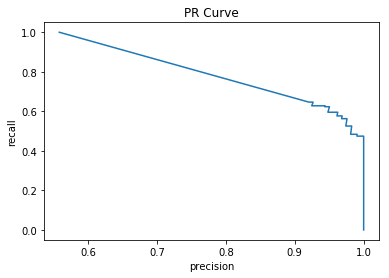

In [74]:
# Calculate precision recall curve
labeled_data[:,1]
precision, recall, thresholds = precision_recall_curve(labeled_data[:,1], score, pos_label='True')

plt.plot(precision, recall)
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("PR Curve")
plt.show()

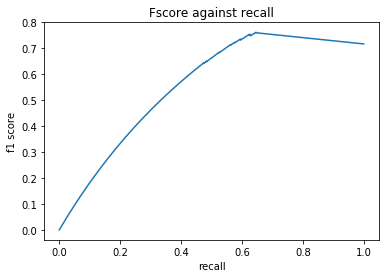

In [76]:
# Calculate fscore
fscore = 2 * (precision * recall) / (precision + recall)

plt.plot(recall, fscore)
plt.xlabel("recall")
plt.ylabel("f1 score")
plt.title("Fscore against recall")
plt.show()

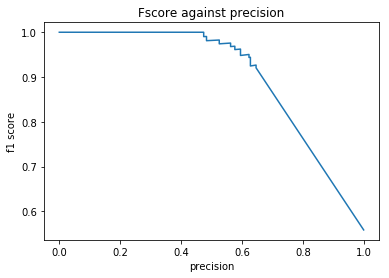

In [78]:
# Calculate fscore
fscore = 2 * (precision * recall) / (precision + recall)

plt.plot(recall, precision)
plt.xlabel("precision")
plt.ylabel("f1 score")
plt.title("Fscore against precision")
plt.show()

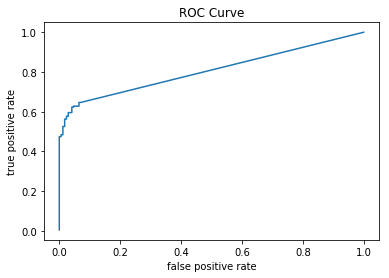

In [81]:
fpr, tpr, thresholds = roc_curve(labeled_data[:,1], score, pos_label='True')

plt.plot(fpr, tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")
plt.show()

In [86]:
### Annoyingly, roc_auc_score doesn't allow you to have arbitrary labels
# map into binary
def binarize(x):
    if(x == 'True'):
        return 1
    else:
        return 0
    
vfunc = np.vectorize(binarize)

labels = labeled_data[:,1]
labels = vfunc(labels)

roc_auc_score(labels, score)

0.80612859097127221

In [ ]:
### TODO NEXT STEPS
# Extract this so that analysis can be re-run with a single command for future models
# Begin learning how to do transfer learning